In [116]:
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.colors
import asilib
import asilib.map
import asilib.asi
import numpy as np
import matplotlib.gridspec
import scipy.interpolate
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

import IRBEM

In [114]:
time = datetime(2021, 11, 4, 7, 3, 51)
location_codes = ['FSMI', 'LUCK', 'RABB', 'PINA', 'GILL']
map_alt = 110
min_elevation = 10
lon_bounds=(-125, -75)
lat_bounds=(40, 70)

In [16]:
irbem_obj = IRBEM.MagFields(kext=0)
coords_obj = IRBEM.Coords()

In [17]:
def map_eq(time, latitudes, longitudes, alt=110):
    """
    Maps geographic coordinates to magnetic equator coordinates using IRBEM.

    Parameters:
    latitudes (numpy.ndarray): 
        Array of latitudes.
    longitudes (numpy.ndarray): 
        Array of longitudes.
    alt (int): 
        Altitude in km.

    Returns:
    numpy.ndarray:
        Mapped locations in the Geocentric Solar Magnetospheric (SM) coordinates.
    """
    sm_coords = np.zeros((latitudes.shape[0], 3))

    for i, (lat, lon) in enumerate(zip(latitudes, longitudes)):
        
        # Trace the magnetic field line to the magnetic equator
        LLA = {'datetime':time, 'x1':alt, 'x2':lat, 'x3':lon}
        output_dictionary = irbem_obj.find_magequator(LLA, {})
        sm_coords[i, :] = coords_obj.transform(time, output_dictionary['XGEO'], 1, 4)  # Convert to SM coordinates
    return sm_coords

In [79]:
_imagers = [asilib.asi.trex_rgb(location_code, time=time, alt=map_alt) for location_code in location_codes]
asis = asilib.Imagers(_imagers)
lats_lons, intensities = asis.get_points()

Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


In [80]:
lats_lons

array([[  55.96598816, -115.88394165],
       [  55.98441315, -115.90515137],
       [  56.00239182, -115.92657471],
       ...,
       [  60.58226395,  -96.37164307],
       [  60.59544373,  -96.41470337],
       [  60.60906601,  -96.45825195]])

In [81]:
intensities

array([[27., 31., 29.],
       [27., 32., 28.],
       [27., 32., 28.],
       ...,
       [24., 31., 22.],
       [25., 32., 22.],
       [26., 32., 26.]])

In [82]:
sm_loc = map_eq(time, lats_lons[:, 0], lats_lons[:, 1], alt=map_alt)

In [90]:
x_grid, y_grid = np.meshgrid(np.linspace(-10, 0, num=1000), np.linspace(-5, 5, num=1001))

In [91]:
# https://stackoverflow.com/a/31189177
tree = cKDTree(sm_loc[:, :2])
xi = _ndim_coords_from_arrays((x_grid, y_grid), ndim=2)
dists, indexes = tree.query(xi)

How far away are the gridded points from the mapped points? If they are too far away we will mask them. 

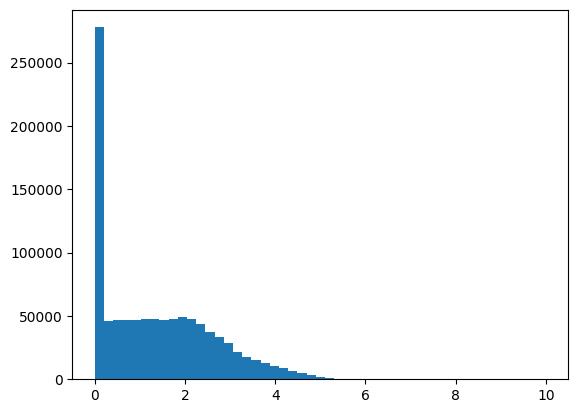

In [92]:
plt.hist(dists.flatten(), bins=np.linspace(0, 10));

In [110]:
gridded_eq_data = scipy.interpolate.griddata(
    sm_loc[:, :2], 
    intensities, 
    (x_grid, y_grid), 
    method='nearest'
    )
gridded_eq_data_copy = gridded_eq_data[...]
gridded_eq_data_copy[dists > 0.1, :] = np.nan  # Mask any gridded point > 0.1 Re from the mapped point as NaN

In [111]:
vmin, vmax = asis.imagers[0].plot_settings['color_bounds']
gridded_eq_data_copy = asis.imagers[0]._stretch_contrast(gridded_eq_data_copy, vmin, vmax)

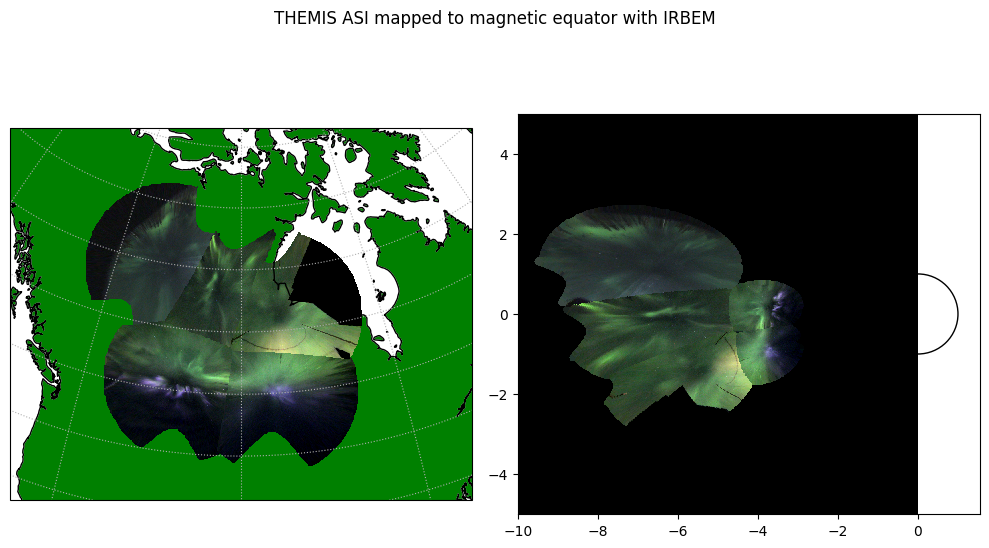

In [121]:
fig = plt.figure(figsize=(10, 6))
gs = matplotlib.gridspec.GridSpec(1, 2, fig, width_ratios=(1, 1))
ax = asilib.map.create_map(fig_ax=(fig, gs[0, 0]), lat_bounds=lat_bounds, lon_bounds=lon_bounds)
bx = fig.add_subplot(gs[0, 1])
bx.set_aspect('equal')

asis.plot_map(ax=ax, asi_label=False)
bx.pcolormesh(x_grid, y_grid, gridded_eq_data_copy)
bx.add_patch(plt.Circle((0, 0), 1, ec='k', fc='None'))

plt.suptitle('THEMIS ASI mapped to magnetic equator with IRBEM')
plt.tight_layout()
plt.show()